In [32]:
print("HI")

HI


In [3]:


# If you clone this repo, please use this
# Or you can also directly install the repo by this
!pip install git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP
!pip install git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip

!pip install git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api
!pip install git+https://github.com/THU-MIG/yoloe.git

!wget https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt

  Cloning https://github.com/THU-MIG/yoloe.git to /tmp/pip-req-build-eomfnzya
  Running command git clone --filter=blob:none --quiet https://github.com/THU-MIG/yoloe.git /tmp/pip-req-build-eomfnzya
  Resolved https://github.com/THU-MIG/yoloe.git to commit 40cd606cabdbe2b566d6f14a6b162c89206e9a1b
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1382284 sha256=6b70bc8a32fbf9edcb5cd9a2d2a1a535b9e3fc3804badb0534992dc0848a56cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-8wqr7uzv/wheels/92/08/49/1e84617d87c35c296dc4e2d10518f344c5b790179d45bfaa93
Successfully built clip
  Cloning https://github.com/THU-MIG/yoloe.git to /tmp/pip-req-build-gnyt6jw8
  Running command git clone --filter=blob:none --quiet https://github.com/THU-MIG/yoloe.git /tmp/pip-req-build-gnyt6jw8
  Resolved https://github.com/THU-MIG/yoloe.git to commit 40cd606cabdbe2b566d6f14a6b162c89

In [9]:
!pip install jupyter_bbox_widget


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


In [27]:
import base64

def encode_image(filepath):
  with open (filepath ,'rb') as f:
    image_bytes =f.read()
  encoded =str(base64.b64encode(image_bytes),'utf-8')
  return "data:image/jpeg;base64,"+encoded

In [49]:
SOURCE_IMAGE_PATH = "/content/source.png"
TARGET_IMAGE_PATH = "/content/target.png"
NAMES =["bee"]

from google.colab import output
output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget =BBoxWidget(classes=NAMES)
widget.image = encode_image(SOURCE_IMAGE_PATH)
widget

BBoxWidget(classes=['bee'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2…

In [50]:
import numpy as np

default_box=[widget.bboxes]

boxes =widget.bboxes if widget.bboxes else default_box
bboxes = np.array([
    [
        box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']
    ]for box in boxes
],dtype=np.float64)
cls= np.array([NAMES.index(box['label'])for box in boxes],dtype=np.int32)


0: 640x640 17 object0s, 1956.8ms
Speed: 6.7ms preprocess, 1956.8ms inference, 54.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bee, 799.9ms
Speed: 3.3ms preprocess, 799.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


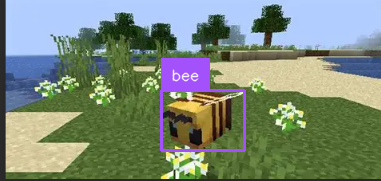

In [51]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor


model = YOLOE("/content/yoloe-11s-seg.pt")
prompts = dict(bboxes=bboxes,cls=cls)

source_image= Image.open(SOURCE_IMAGE_PATH)
target_image= Image.open(TARGET_IMAGE_PATH)

model.predict(source_image,prompts=prompts,predictor=YOLOEVPSegPredictor,return_vpe=True)
model.set_classes(NAMES,model.predictor.vpe)
model.predictor =None

results = model.predict(target_image)
detection = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image =sv.BoxAnnotator().annotate(scene=(annotated_image),detections=detection)
annotated_image =sv.LabelAnnotator().annotate(scene=annotated_image,detections=detection)
annotated_image